In [1]:
# connect to mlflow server
import mlflow

mlflow.set_tracking_uri("http://0.0.0.0:5001")

mlflow.set_experiment("NTPC-lstm-Model")

<Experiment: artifact_location='mlflow-artifacts:/518416412105918584', creation_time=1744456072057, experiment_id='518416412105918584', last_update_time=1744456072057, lifecycle_stage='active', name='NTPC-lstm-Model', tags={}>

In [2]:
# Set up logging to a file
import logging
import os

# Get current working directory
log_file_path = os.path.join(os.getcwd(), 'mlflow_run.log')

# Set up the logger manually
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Remove all previous handlers (important in Jupyter)
logger.handlers.clear()

# Create and add FileHandler
file_handler = logging.FileHandler(log_file_path, mode='w')
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

# Optional: also log to console
console_handler = logging.StreamHandler()
console_handler.setFormatter(formatter)
logger.addHandler(console_handler)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import random

def set_seed(seed=42):
    """
    Set the seed for reproducibility in PyTorch, NumPy, and Python's random module.
    Ensures deterministic behavior on CPU, CUDA, and MPS.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)  # Works for CPU & MPS

    if torch.backends.mps.is_available():
        logging.info("MPS backend is available. It uses the global PyTorch seed.")

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # Multi-GPU
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    torch.use_deterministic_algorithms(True, warn_only=True)
    logging.info("Deterministic algorithms set to True.")
    logging.info("Random seed set to: %d", seed)

# Example usage
global_seed = 42
set_seed(global_seed)

2025-04-12 17:37:15,500 - INFO - MPS backend is available. It uses the global PyTorch seed.
2025-04-12 17:37:15,501 - INFO - Deterministic algorithms set to True.
2025-04-12 17:37:15,501 - INFO - Random seed set to: 42


In [4]:
from sklearn.preprocessing import MinMaxScaler

# Parameters
train_size = 0.9
test_size = 0.1
assert train_size + test_size == 1, "Train and test sizes must sum to 1"

# Load dataset
data = pd.read_csv('../../Data/processed_data/NTPC.csv')
logger.info(f"Loaded data shape: {data.shape}")

# Initialize scaler for normalization
scaler = MinMaxScaler(feature_range=(0, 1))

# Dataset splitting
split_index = int(len(data) * train_size)
train_data = data.iloc[:split_index]
test_data = data.iloc[split_index:]

# Reset indices
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# Normalize the "Close" column in both train and test sets
target_column = 'Close'
train_data[target_column] = scaler.fit_transform(train_data[[target_column]])
test_data[target_column] = scaler.transform(test_data[[target_column]])

logger.info(f"Train data shape: {train_data.shape}")
logger.info(f"Test data shape: {test_data.shape}")


2025-04-12 17:37:15,878 - INFO - Loaded data shape: (4088, 13)
2025-04-12 17:37:15,883 - INFO - Train data shape: (3679, 13)
2025-04-12 17:37:15,883 - INFO - Test data shape: (409, 13)


In [5]:
from torch.utils.data import Dataset, DataLoader

SEQ_LENGTH = 30   # number of time steps per input sequence
BATCH_SIZE = 64
HIDDEN_SIZE = 64
NUM_LAYERS = 2
INPUT_SIZE = 1

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

target_column = 'Close'
train_seq, train_target = create_sequences(train_data[target_column].values, SEQ_LENGTH)
test_seq, test_target = create_sequences(test_data[target_column].values, SEQ_LENGTH)

class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, targets):
        self.x = torch.tensor(sequences, dtype=torch.float32).unsqueeze(-1)
        self.y = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_dataset = TimeSeriesDataset(train_seq, train_target)
test_dataset = TimeSeriesDataset(test_seq, test_target)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [6]:
from torch import nn
class LSTMModel(nn.Module):
    def __init__(self, input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, 
                           hidden_size=hidden_size, 
                           num_layers=num_layers, 
                           batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # LSTM returns (output, (h_n, c_n)) for hidden state and cell state
        out, _ = self.lstm(x)
        # Still using only the last time step
        return self.fc(out[:, -1, :])


In [7]:
def train(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    epoch_loss = 0

    for sequences, targets in train_loader:
        sequences, targets = sequences.to(device), targets.to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    mlflow.log_metric("train_loss", avg_loss, step=epoch+1)
    logging.info(f"Epoch {epoch+1}: Train Loss = {avg_loss:.4f}")


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100

def validate(model, val_loader, criterion, device, epoch, scaler):
    model.eval()
    all_preds = []
    all_targets = []
    total_loss = 0.0

    with torch.no_grad():
        for sequences, targets in val_loader:
            sequences, targets = sequences.to(device), targets.to(device).unsqueeze(1)
            outputs = model(sequences)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    # Convert to numpy arrays and inverse transform
    y_true_normalized = np.array(all_targets).reshape(-1, 1)
    y_pred_normalized = np.array(all_preds).reshape(-1, 1)
    
    # Inverse transform to original scale
    y_true = scaler.inverse_transform(y_true_normalized).flatten()
    y_pred = scaler.inverse_transform(y_pred_normalized).flatten()

    # Calculate metrics on original scale
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    # Logging
    logging.info(f"Epoch {epoch+1} - Val MSE: {mse:.6f}, RMSE: {rmse:.6f}, MAE: {mae:.6f}, R²: {r2:.6f}, MAPE: {mape:.6f}%")
    mlflow.log_metric("val_MSE", mse, step=epoch+1)
    mlflow.log_metric("val_RMSE", rmse, step=epoch+1)
    mlflow.log_metric("val_MAE", mae, step=epoch+1)
    mlflow.log_metric("val_R2", r2, step=epoch+1)
    mlflow.log_metric("val_MAPE", mape, step=epoch+1)

    return rmse, mse, mae, r2, mape  # Returns RMSE on original scale


In [8]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0, verbose=False):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.verbose = verbose
        self.best_model_state = None

    def __call__(self, val_loss, model):
        if self.best_score is None or val_loss < self.best_score - self.min_delta:
            self.best_score = val_loss
            self.counter = 0
            self.best_model_state = model.state_dict()
            if self.verbose:
                logging.info(f"Monitored metric improved to {val_loss:.6f}")
        else:
            self.counter += 1
            if self.verbose:
                logging.info(f"Monitored metric did not improve. Counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    logging.warning("Early stopping triggered.")

In [9]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Initialize model
model = LSTMModel(input_size=1, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS)


criterion_train = nn.MSELoss()
criterion_val = nn.MSELoss()


# Initialize optimizer
starting_lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=starting_lr)


# Initialize learning rate scheduler
scheduler_mode = 'min'
scheduler_factor = 0.25
scheduler_patience = 2
scheduler_cooldown = 0
scheduler_min_lr = 1e-6
scheduler_threshold = 0.0001
scheduler_threshold_mode = 'abs'

scheduler = ReduceLROnPlateau(optimizer, mode=scheduler_mode,
                              factor=scheduler_factor,
                              patience=scheduler_patience,
                              cooldown=scheduler_cooldown,
                              min_lr=scheduler_min_lr,
                              threshold=scheduler_threshold,
                              threshold_mode=scheduler_threshold_mode,
                              verbose=True)

# Initialize early stopping
early_stopping_patience = scheduler_cooldown + scheduler_patience + 4
early_stopping_delta = scheduler_threshold/2
early_stopping = EarlyStopping(patience=early_stopping_patience,
                               verbose=True,
                               min_delta=early_stopping_delta)  # noqa: E501

max_num_epochs = 300

# Check device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.backends.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
logging.info(f"Using device: {device.type}")
# Move model to device
model.to(device)


# Log params as a dictionary
params = {
    "global_seed": global_seed,
    "train_batch_size": train_size,
    "eval_batch_size": test_size,
    "loss_function": "MSELoss",
    "model_SEQ_LENGTH": SEQ_LENGTH,
    "model_HIDDEN_SIZE": HIDDEN_SIZE,
    "model_BATCH_SIZE": BATCH_SIZE,
    "model_NUM_LAYERS": NUM_LAYERS,
    "learning_rate": starting_lr,
    "optimizer": "Adam",
    "scheduler_mode": scheduler_mode,
    "scheduler_factor": scheduler_factor,
    "scheduler_patience": scheduler_patience,
    "scheduler_cooldown": scheduler_cooldown,
    "scheduler_min_lr": scheduler_min_lr,
    "scheduler_therhold": scheduler_threshold,
    "scheduler_threshold_mode": scheduler_threshold_mode,
    "scheduler": "ReduceLROnPlateau",
    "early_stopping_patience": early_stopping_patience,
    "early_stopping_delta": early_stopping_delta,
    "max_epochs": max_num_epochs,
    "device": device.type,
}


/opt/miniconda3/envs/MCV/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
2025-04-12 17:37:16,716 - INFO - Using device: mps


In [10]:
from torchinfo import summary

# Start MLflow run
with mlflow.start_run() as run:
    run_id = run.info.run_id
    logging.info(f"Started MLflow run with ID: {run_id}")

    # Log parameters
    try:
        mlflow.log_params(params)
        logging.info("Logged params to MLflow")
    except Exception as e:
        logging.error(f"Failed to log parameters: {e}")

    # Save model summary
    try:
        model_summary = summary(
            model, 
            input_size=(BATCH_SIZE, SEQ_LENGTH, INPUT_SIZE),
            device=device.type
        )
        with open("model_report.txt", "w") as f:
            f.write("### MODEL ARCHITECTURE ###\n")
            f.write(str(model))
            f.write("\n\n### MODEL SUMMARY ###\n")
            f.write(str(model_summary))
        mlflow.log_artifact("model_report.txt")
        os.remove("model_report.txt")
    except Exception as e:
        logging.error(f"Failed to log model report: {e}")

    logging.info("Starting training...")

    # Initialize metrics
    best_rmse = float('inf')
    best_save_epoch = 0

    for epoch in range(max_num_epochs):
        try:
            current_lr = optimizer.param_groups[0]['lr']
            logging.info(f"Epoch {epoch + 1}, LR: {current_lr}")
            mlflow.log_metric("learning_rate", current_lr, step=epoch+1)

            train_loss = train(model, train_loader, criterion_train, optimizer, device, epoch)
            rmse, mse, mae, r2, mape = validate(model, test_loader, criterion_val, device, epoch, scaler)

            scheduler.step(rmse)

            if rmse < best_rmse:
                best_metric = rmse
                best_save_epoch = epoch
                best_train_loss = train_loss
                best_mse = mse
                best_mae = mae
                best_r2 = r2
                best_mape = mape
                mlflow.pytorch.log_model(model, "best_model")

            mlflow.pytorch.log_model(model, "latest_model")

            early_stopping(rmse, model)
            if early_stopping.early_stop:
                mlflow.log_param("best_epoch", best_save_epoch)
                break

        except Exception as e:
            logging.error(f"Training failed at epoch {epoch}: {e}")
            break

    # Log final metrics
    try:
        mlflow.log_param("best_rmse", best_rmse)
        mlflow.log_param("best_epoch", best_save_epoch)
        mlflow.log_param("best_train_loss", best_train_loss)
        mlflow.log_param("best_mse", best_mse)
        mlflow.log_param("best_mae", best_mae)
        mlflow.log_param("best_r2", best_r2)
        mlflow.log_param("best_mape", best_mape)
    except Exception as e:
        logging.error(f"Failed to log best metrics: {e}")

    # Handle log file
    try:
        if os.path.exists("mlflow_run.log"):
            mlflow.log_artifact("mlflow_run.log")
            os.remove("mlflow_run.log")
    except Exception as e:
        logging.error(f"Failed to handle log file: {e}")
    finally:
        logger.handlers.clear()


2025-04-12 17:37:16,845 - INFO - Started MLflow run with ID: afd6fcc7f6b2470faccae40c81c4a3e8
2025-04-12 17:37:16,853 - INFO - Logged params to MLflow
2025-04-12 17:37:17,132 - INFO - Starting training...
2025-04-12 17:37:17,147 - INFO - Epoch 1, LR: 0.001
2025-04-12 17:37:18,159 - INFO - Epoch 1: Train Loss = 0.0467
2025-04-12 17:37:18,238 - INFO - Epoch 1 - Val MSE: 1966.659668, RMSE: 44.347037, MAE: 43.405865, R²: -13.829624, MAPE: 45.145855%
2025/04/12 17:37:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/04/12 17:37:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025-04-12 17:37:26,964 - INFO - Monitored metric improved to 44.347037
2025-04-12 17:37:26,964 - INFO - Epoch 2, LR: 0.001
2025-04-12 17:37:27,509 - INFO - E

🏃 View run silent-wolf-9 at: http://0.0.0.0:5001/#/experiments/518416412105918584/runs/afd6fcc7f6b2470faccae40c81c4a3e8
🧪 View experiment at: http://0.0.0.0:5001/#/experiments/518416412105918584


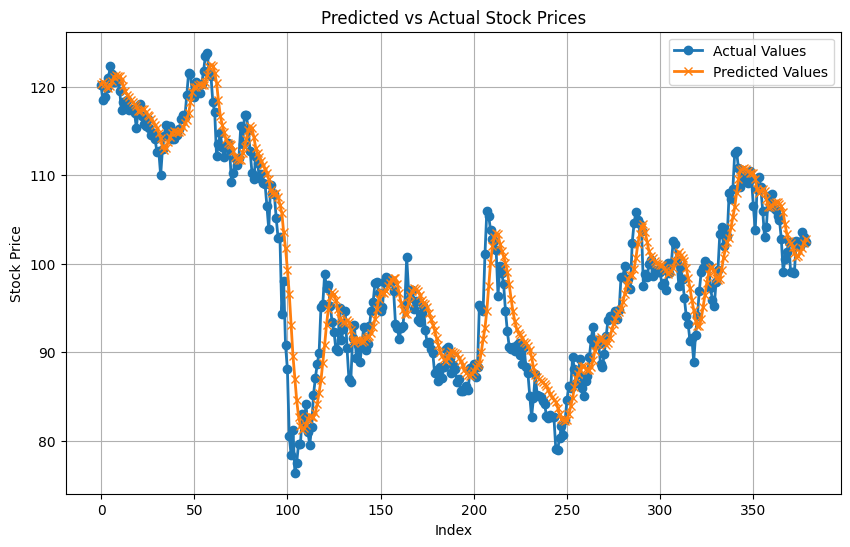

In [11]:
# After loading your best model
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for sequences, targets in test_loader:
        sequences = sequences.to(device)
        outputs = model(sequences)
        all_preds.extend(outputs.cpu().numpy())
        all_targets.extend(targets.numpy())

# Inverse transform predictions and actual values
y_pred_normalized = np.array(all_preds).reshape(-1, 1)
y_true_normalized = np.array(all_targets).reshape(-1, 1)
y_pred = scaler.inverse_transform(y_pred_normalized).flatten()
y_true = scaler.inverse_transform(y_true_normalized).flatten()

# Plot with original scale values
plt.figure(figsize=(10, 6))
plt.plot(y_true, label='Actual Values', marker='o', linewidth=2)
plt.plot(y_pred, label='Predicted Values', marker='x', linewidth=2)
plt.title('Predicted vs Actual Stock Prices')
plt.xlabel('Index')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()